# Bayesian Optimization

[Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is used to solve an optimization problem
$$ x^* = \text{arg}\min \ f(x), $$
where $f$ is an unknown objective function which
+ hard to compute,
+ has no derivative,
+ observations of $f$ contain noise.

An optimization process includes constructing a sequence of points $\{x_n\}$ which converges to $x^*$. However, due to the above restrictions, it is hard to construct such sequence using information directly from $f$. In Bayesian Optimization, we put a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) prior on $f$ and derive from it an "acquisition" function $\alpha(x)$ which is easy to evaluate and get derivatives (hence optimizing $\alpha(x)$ is easy). This "acquisition" function encodes the following information about $f$: its minimum is a candidate for $x_n$.

Each time we get more information from $f$, the Gaussian Process model will be updated (similar to the way we update posteriors in Bayesian models) and the derived "acquisition" function will reflect more information about the minimum point of $f$. After a number of steps, it is likely that $\{x_n\}$ will converge to $x^*$.

In this tutorial, we will see how to use the Gaussian Process module in Pyro to do Bayesian Optimization.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
from pyro.contrib.gp.kernels import Matern32
from pyro.contrib.gp.models import GPRegression
from pyro.optim import Adam
pyro.set_rng_seed(0)

import os
smoke_test = ('CI' in os.environ)

## Define a problem

The objective function we are going to solve is
$$f(x) = \frac{x^2}{10} + \sin(x), \quad x\in [-10, 10].$$

In [2]:
def f(x):
    return x**2 / 10 + torch.sin(x)

Its minimum is $-1.30644$. Let's take a plot for $f$.

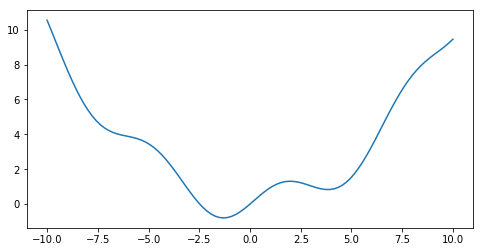

In [3]:
x = torch.linspace(-10, 10)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

## Set a Gaussian Process prior

We will use a Gaussian Process Regression model as a prior (a distribution over functions) on $f$ and initialize it with three initial points $-11$ and $11$. Choosing a proper covariance kernel is also very important. Here we use [Matern32](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) kernel.

In [4]:
X = torch.tensor([-11, 11])
y = f(X)
gpmodel = GPRegression(X, y, Matern32(1), noise=torch.tensor(0.01), jitter=1e-4)

The following helper function `update_posterior` will take care of updating our `gpmodel` when a new $x$ is found.

In [5]:
def update_posterior(x_new):
    y = f(x_new)
    X = torch.cat([gpmodel.X, x_new])
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    gpmodel.optimize()

## Define an acquisition function

We will use the acquisition Lower Confidence Bound (see reference [1]). Its definition is
$$
\alpha(x) = \mu(x) - \kappa \sigma(x),\quad \kappa = 2,
$$
where $\mu(x)$ and $\sigma(x)$ are mean and variance of Gaussian Process posterior. The coefficient $\kappa$ plays a trade-off between exploitation-exploration. A high $\kappa$ means that we play more weight on exploration (because we seek minimum candidates in a higher-uncertainty area). Otherwise, we do exploitation: seek minimum candidates around the posterior mean $\mu(x)$.

In [6]:
def lower_confidence_bound(x, kappa=2):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

The final component is a way to find a minimum point for acquisition function. There are several ways for us to choose: gradient-based and non-gradient-based. Here, we will follow the gradient-based approach. One of the drawback of gradient descent methods is it is easy for the minimizer to get stuck at a local minimum. In this tutorial, we will use a simple way to solve that problem. First, draw $5$ samples from our Gaussian Process posteriors and find a candidate for each sample. Then (after collecting $5$ candidates), we select the minimum point among them. A more detailed discussion regarding to this problem in Bayesian Optimization is presented in the reference [2].

In [7]:
def find_a_candidate(x_init, lower_bound=-10, upper_bound=10):
    # transform x to an unconstrained domain to set an minimizer for it
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = torch.tensor(unconstrained_x_init, requires_grad=True)
    minimizer = optim.LBFGS([unconstrained_x])

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y
    
    minimizer.step(closure)
    # after a candidate found in unconstrained domain, convert it back to original domain
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

In [8]:
def next_x(lower_bound=-10, upper_bound=10, num_candidates=3):
    candidates = []
    values = []

    # last data point will be an init point for first minimum candidate,
    # other minimum candidates will get uniform random initialization
    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        x = find_a_candidate(x_init, lower_bound, upper_bound)
        y = lower_confidence_bound(x)
        candidates.append(x)
        values.append(y)
        x_init = x.new(1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    return candidates[argmin]

## Find $\{ x_n \}$

To illustrate how Bayesian Optimization works, we make a convenient plotting function.

In [9]:
def plot(gs, xmin, xlabel=None, with_title=True):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-11, 11)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot prediction mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-11, 11)
    ax1.set_title("Find {}".format(xlabel))
    if with_title:
        ax1.set_ylabel("Gaussian Process Regression")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())  # plot acquisition function
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))  # plot minimum point
    ax2.set_xlim(-11, 11)
    if with_title:
        ax2.set_ylabel("Lower Confidence Bound")
    ax2.legend(loc=1)

First, we generate a random point `x0` in the interval $[-10, 10]$. Then update Gaussian Process posterior and find the minimum point from the derived acquisition function. All together will be presented in the below plot.

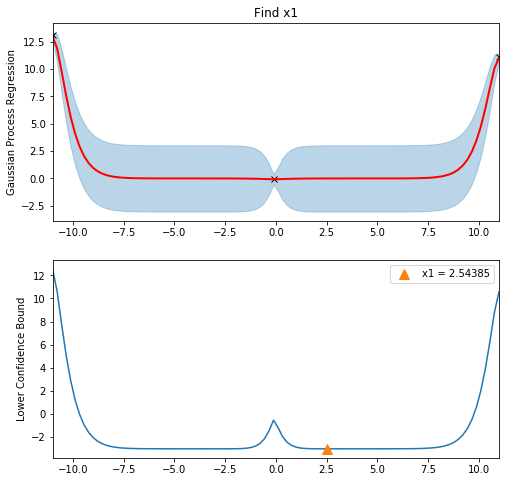

In [10]:
x0 = X.new(1).uniform_(-10, 10)
update_posterior(x0)
x1 = next_x()

plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1)
plot(gs, x1, 1)

The following plot illustrates how Gaussian Process posteriors and their derived acquisition functions change when we observe more data for the next $6$ steps.

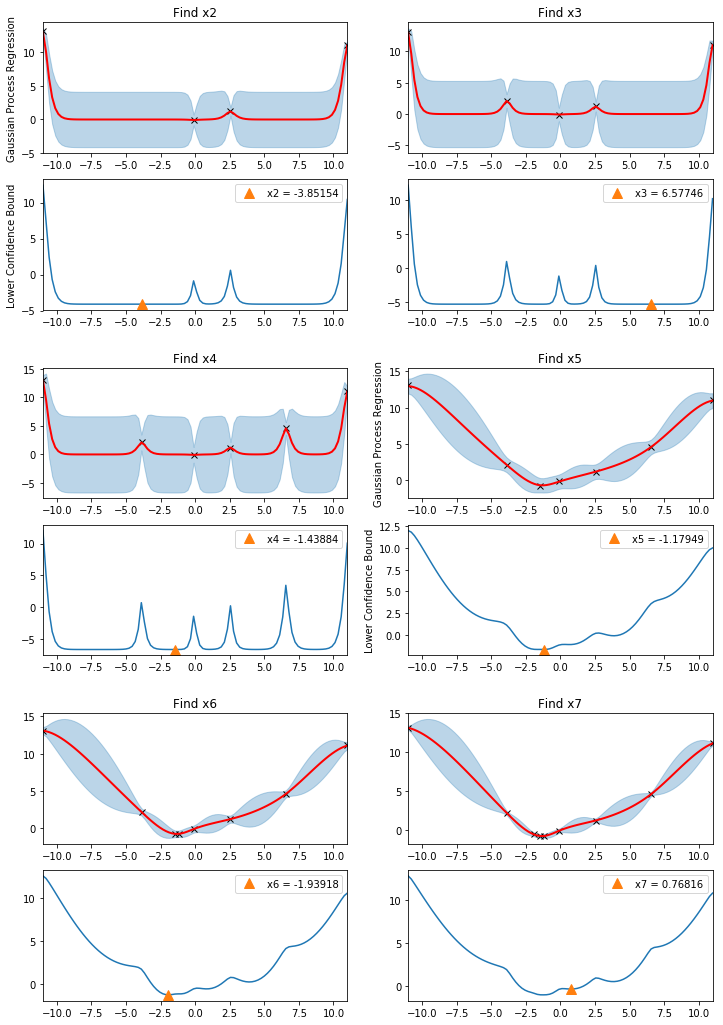

In [11]:
num_steps = 6 if not smoke_test else 1
plt.figure(figsize=(12, 18))
outer_gs = gridspec.GridSpec(3, 2)
xmin = x1
for i in range(num_steps):
    update_posterior(xmin)
    xmin = next_x()
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    plot(gs, xmin, xlabel=i+2, with_title=(i % 3 == 0))

The last subplot shows that the acquisition can not find its global minimum. This is a drawback of gradient descent methods! However, it seems that the posterior mean approximates pretty well to the objective $f$. We hope to obtain the global minimum with a few more steps.

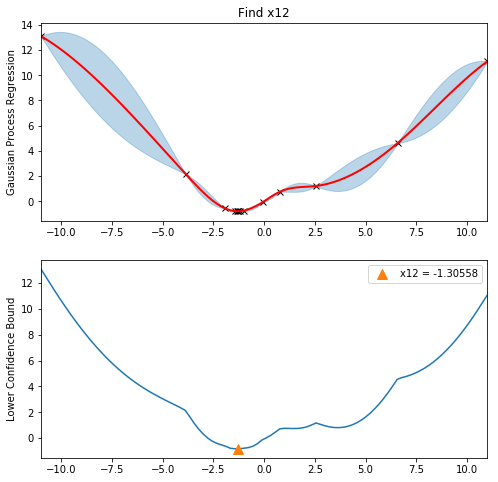

In [12]:
num_steps = 5 if not smoke_test else 1
for i in range(num_steps):
    update_posterior(xmin)
    xmin = next_x()
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1)
plot(gs, xmin, num_steps+7)

Because we made an assumption that our observations contain noise, it is improbable to require an exact result. However, we can see that the sequence has converged to near the global minimum $-1.30644$. That's it! Through this tutorial, we hope that we have conveyed some basic ideas of Bayesian Optimization. For more reference, the youtube video [3] is an excellent course to learn the basic theory. And the paper [2] gives a review of current progresses on this subject, together with many discussions about technical details.

## References

[1] `Practical bayesian optimization of machine learning algorithms`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Jasper Snoek, Hugo Larochelle, and Ryan P. Adams

[2] `Taking the human out of the loop: A review of bayesian optimization`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Bobak Shahriari, Kevin Swersky, Ziyu Wang, Ryan P. Adams, and Nando De Freitas

[3] [Machine learning - Bayesian optimization and multi-armed bandits](https://www.youtube.com/watch?v=vz3D36VXefI)